# <center> Data Collection </center>

Collect system logs containing CPU usage, memory consumption, disk I/O, and other relevant metrics for predictive maintenance.


*************************************************************************************************************************************************


#### PowerShell Script: Export System Metrics

The following PowerShell script collects system metrics every 5 seconds and appends them to a CSV file. This data will be used for further analysis.

In [ ]:
# PowerShell: Generate System Metrics Log
# This script runs 50 times, every 5 seconds, to generate sample logs for system metrics.

$Counters = @(
    '\Processor(_Total)\% Processor Time',
    '\Processor(_Total)\% Privileged Time',
    '\System\Processor Queue Length',
    '\Memory\Pages/sec',
    '\Memory\Committed Bytes',
    '\PhysicalDisk(_Total)\Avg. Disk Queue Length',
    '\LogicalDisk(_Total)\% Free Space',
    '\Network Interface(*)\Bytes Total/sec'
)

for ($i = 1; $i -le 50; $i++) {
    $Sample = Get-Counter -Counter $Counters
    $Data = [PSCustomObject]@{
        Timestamp = Get-Date -Format "MM/dd/yyyy HH:mm:ss" # Explicitly format the timestamp
    }

    foreach ($counter in $Sample.CounterSamples) {
        $name = ($counter.Path -replace '^.*\\', '') -replace '[^a-zA-Z0-9 %]', '_'
        $Data | Add-Member -NotePropertyName $name -NotePropertyValue $counter.CookedValue
    }

    $Data | Export-Csv "C:\AI_Project\logs\system_metrics.csv" -Append -NoTypeInformation
    Start-Sleep -Seconds 5
}

#### PowerShell Script: Export Windows Event Log

This script exports the Windows System Event Log to a CSV file for further analysis.

In [ ]:
# PowerShell: Export System Event Log
Get-EventLog -LogName System | Export-Csv -Path "C:\AI_Project\logs\system_logs.csv" -NoTypeInformation


# <center> Data Preprocessing </center>

Pass the log file paths and combined log path. Clean the data, handle missing values, and normalize the features for further processing.

*******************************************************************************************************************************


In [34]:
import sys
import os
import glob
import pandas as pd
sys.path.append('C:/AI_Project/src')
from preprocess import process_system_metrics


# Directory containing raw system metrics CSV files
log_dir = 'C:/AI_Project/data/raw_logs'
processed_dir = 'C:/AI_Project/data/processed_logs'
os.makedirs(processed_dir, exist_ok=True)

# Only process system metrics CSVs (no system logs or event features)
#metrics_files = glob.glob(os.path.join(log_dir, 'systems_metrics*.csv'))
metrics_files = glob.glob(os.path.join(log_dir, '*.csv'))
print(f"Found {len(metrics_files)} system metrics files:", metrics_files)

# Process each file in memory and collect DataFrames
all_dfs = []
for metrics_path in metrics_files:
    df = process_system_metrics(metrics_path)
    all_dfs.append(df)

# Combine all processed DataFrames into a single DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.sort_values('Timestamp')

# Save the combined DataFrame as a single JSON file for modeling
combined_json_path = os.path.join(processed_dir, 'combined_system_metrics.json')
combined_df.to_json(combined_json_path, orient='records', indent=4)
print(f"Combined system metrics saved to: {combined_json_path}")


Found 5 system metrics files: ['C:/AI_Project/data/raw_logs\\systems_metrics_22_06.csv', 'C:/AI_Project/data/raw_logs\\systems_metrics_23_06.csv', 'C:/AI_Project/data/raw_logs\\system_metrics.csv', 'C:/AI_Project/data/raw_logs\\system_metric_failure.csv', 'C:/AI_Project/data/raw_logs\\system_metric_success.csv']
Shape: (1441, 10)
            Timestamp  % processor time  % privileged time  \
0 2025-06-20 00:00:00         52.483571          12.933685   
1 2025-06-20 00:01:00         49.315623          10.456026   
2 2025-06-20 00:02:00         53.252332           6.764865   
3 2025-06-20 00:03:00         57.635983          11.009637   
4 2025-06-20 00:04:00         48.857011           8.385497   

   processor queue length  pages_sec  committed bytes  avg_ disk queue length  \
0                0.696567   9.233209     1.205360e+10                0.107841   
1                1.228843  12.374808     1.184065e+10                0.114062   
2                0.373752  30.363029     1.231336e+1

# <center>Feature Engineering </center>

Generate labels and engineered features from the combined logs. Update the paths as needed to generate new feature files.

*************************************************************************************************************************************************


In [35]:
import os
import sys
import pandas as pd

# Add your module path so we can import custom code
sys.path.append('C:/AI_Project/src')

from feature_engineering import build_features_with_labels
from label_generator import generate_synthetic_labels

# Define file paths
base_dir = 'C:/AI_Project/data'
processed_dir = os.path.join(base_dir, 'processed_logs')
os.makedirs(processed_dir, exist_ok=True)

# Input: combined system metrics
combined_path = os.path.join(processed_dir, 'combined_system_metrics.json')
output_path = os.path.join(processed_dir, 'engineered_features.json')

# Load and prepare combined system metrics
df = pd.read_json(combined_path)

# Feature engineering (auto-detect metric columns)
features_df = build_features_with_labels(df)

# Label generation (auto-detect metric columns)
features_with_labels = generate_synthetic_labels(features_df)

# Save the final engineered features with labels
features_with_labels.to_json(output_path, orient='records', indent=4)
print(f"Engineered features with labels saved to: {output_path}")


Engineered features with labels saved to: C:/AI_Project/data\processed_logs\engineered_features.json


# <center> Model Training & Evaluation </center>

Train and evaluate an XGBoost model using the engineered features.

*************************************************************************************************************************************************





Existing model found. Loading and updating...


c:\Users\lingr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:34:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1169
           1       1.00      1.00      1.00        14

    accuracy                           1.00      1183
   macro avg       1.00      1.00      1.00      1183
weighted avg       1.00      1.00      1.00      1183

ROC AUC Score: 1.0


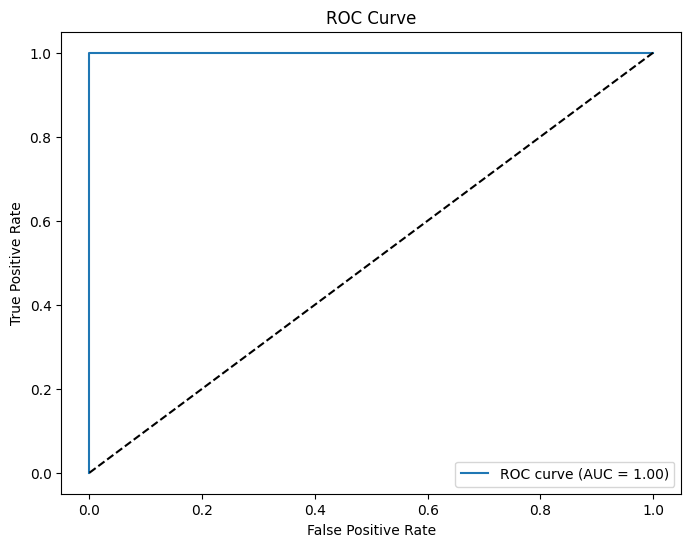

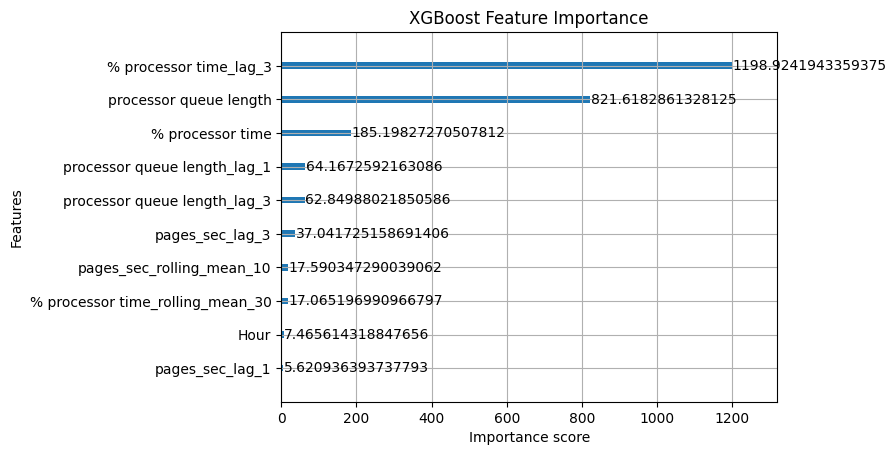

Model saved to: C:/AI_Project/models/xgboost_model.pkl


In [ ]:
import os
import pandas as pd
import sys
sys.path.append('C:/AI_Project/src')
from train_model import split_data, train_xgboost_classifier, evaluate_model, save_model, load_model, retrain_model

# Load engineered features with labels
data_path = 'C:/AI_Project/data/processed_logs/engineered_features.json'
df = pd.read_json(data_path)

target = 'failure_coming'
# Drop only the target column from features before training
X = df.drop(columns=[target])
y = df[target]

# Split data
X_train, X_test, y_train, y_test = split_data(df, target=target)
# Ensure 'failure_coming' is not in X_train/X_test
for col in [target]:
    if col in X_train.columns:
        X_train = X_train.drop(columns=[col])
    if col in X_test.columns:
        X_test = X_test.drop(columns=[col])

# Model path
model_path = 'C:/AI_Project/models/xgboost_model.pkl'

# Train or update model
if os.path.exists(model_path):
    print('Existing model found. Loading and updating...')
    model = load_model(model_path)
    model = retrain_model(model, X_train, y_train)
else:
    print('No existing model found. Training new model...')
    model = train_xgboost_classifier(X_train, y_train)

# Evaluate model
evaluate_model(model, X_test, y_test)

# Save model
save_model(model, model_path)

# <center> Predict Failure </center>

Use the trained model to make predictions on new data.

*************************************************************************************************************************************************


Predictions on new failure data:


,Timestamp,Predicted_Failure,Failure_Probability
0,2025-07-02 00:00:00,0,0.291468
1,2025-07-02 00:01:00,1,0.709154
2,2025-07-02 00:02:00,1,0.956155
3,2025-07-02 00:03:00,1,0.780078
4,2025-07-02 00:04:00,0,0.253322


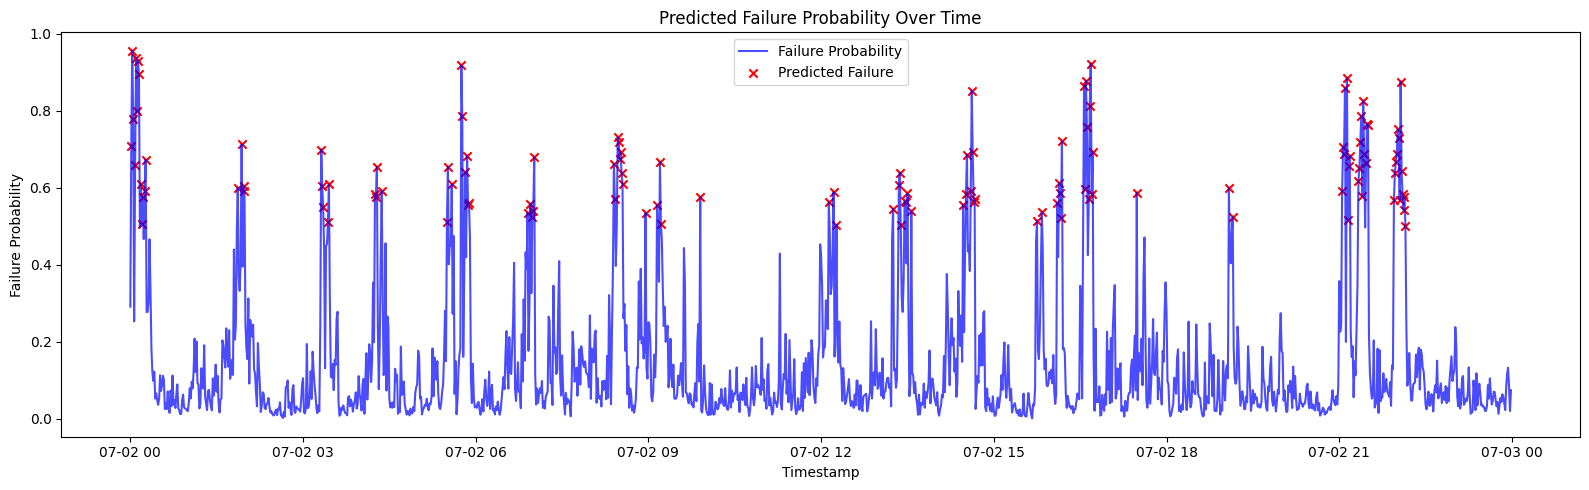


Records predicted as failure:


,Timestamp,Predicted_Failure,Failure_Probability
1,2025-07-02 00:01:00,1,0.709154
2,2025-07-02 00:02:00,1,0.956155
3,2025-07-02 00:03:00,1,0.780078
5,2025-07-02 00:05:00,1,0.659851
6,2025-07-02 00:06:00,1,0.938454
...,...,...,...
1325,2025-07-02 22:05:00,1,0.644162
1326,2025-07-02 22:06:00,1,0.585301
1327,2025-07-02 22:07:00,1,0.543291
1328,2025-07-02 22:08:00,1,0.576601


In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Add src directory to path
sys.path.append('C:/AI_Project/src')
from predict_failure import load_model, prepare_features, predict_failures

# Paths
#engineered_features_path = 'C:/AI_Project/data/processed_logs/feature_system_metric_failure.json'  # Use the new failure features
engineered_features_path = 'C:/AI_Project/data/processed_logs/feature_system_metric_success.json'  # Use the new failure features
model_path = 'C:/AI_Project/models/xgboost_model.pkl'

# Load training columns from training data
train_df = pd.read_json(engineered_features_path)
target = 'failure_coming'
non_numeric_columns = train_df.select_dtypes(exclude=['number']).columns.tolist()
if target in non_numeric_columns:
    non_numeric_columns.remove(target)
train_columns = [col for col in train_df.columns if col not in non_numeric_columns + [target]]
if target in train_columns:
    train_columns.remove(target)  # <-- Ensure target is not in features

# Make predictions and get probabilities using the correct function signature
results_df = predict_failures(model_path, engineered_features_path, train_columns)

# Display results
print("Predictions on new failure data:")
display(results_df.head())

# Plot predictions and failures over time
if 'Timestamp' in train_df.columns:
    results_df = results_df.copy()
    results_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
    plt.figure(figsize=(16, 5))
    plt.plot(results_df['Timestamp'], results_df['Failure_Probability'], label='Failure Probability', color='blue', alpha=0.7)
    plt.scatter(results_df.loc[results_df['Predicted_Failure'] == 1, 'Timestamp'],
                results_df.loc[results_df['Predicted_Failure'] == 1, 'Failure_Probability'],
                color='red', label='Predicted Failure', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Failure Probability')
    plt.title('Predicted Failure Probability Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Timestamp column not found for plotting.")

# Optionally, filter and display only predicted failures
predicted_failures = results_df[results_df['Predicted_Failure'] == 1]
print("\nRecords predicted as failure:")
display(predicted_failures)




************************************************************************************************************************************************


## Generate Synthetic System Metrics Data

Create a synthetic dataset for system metrics that includes realistic trends and variations for the key metric columns 


*******************************************************************************************************************************



#### Failure Data Set

In [27]:
import numpy as np
import pandas as pd
import os

# Output path for new synthetic failure data
base_dir = 'C:/AI_Project/data'
raw_dir = os.path.join(base_dir, 'raw_logs')
os.makedirs(raw_dir, exist_ok=True)
metrics_output_path = os.path.join(raw_dir, 'system_metric_failure.csv')

# Time range: 1 day, 1-min intervals
start_time = pd.to_datetime('2025-06-25 00:00:00')
end_time = pd.to_datetime('2025-06-25 23:59:00')
timestamps = pd.date_range(start=start_time, end=end_time, freq='1min')

metric_cols = [
    "% processor time", "% privileged time", "processor queue length", "pages_sec",
    "committed bytes", "avg_ disk queue length", "% free space", "bytes total_sec"
]
synthetic_metrics_df = pd.DataFrame({'Timestamp': timestamps})

np.random.seed(123)
for col in metric_cols:
    noise = np.random.randn(len(timestamps)) * 5
    trend = np.linspace(0, 10, len(timestamps))
    if col == "% processor time":
        synthetic_metrics_df[col] = np.abs(40 + noise + trend)
    elif col == "% privileged time":
        synthetic_metrics_df[col] = np.abs(8 + noise/2 + trend/2)
    elif col == "processor queue length":
        synthetic_metrics_df[col] = np.abs(1 + noise/10)
    elif col == "pages_sec":
        synthetic_metrics_df[col] = np.abs(15 + noise*2)
    elif col == "committed bytes":
        synthetic_metrics_df[col] = np.abs(1.1e10 + noise*1e8 + trend*1e7)
    elif col == "avg_ disk queue length":
        synthetic_metrics_df[col] = np.abs(0.1 + noise/100)
    elif col == "% free space":
        synthetic_metrics_df[col] = np.clip(np.abs(60 - trend*0.5 + noise), 0, 100)
    elif col == "bytes total_sec":
        synthetic_metrics_df[col] = np.abs(900 + noise*50 + trend*10)
    else:
        synthetic_metrics_df[col] = np.random.rand(len(timestamps)) * 100

# Inject a strong failure pattern in the last 2 hours
failure_start = end_time - pd.Timedelta(hours=2)
failure_window = synthetic_metrics_df['Timestamp'] >= failure_start
for col in ["% processor time", "processor queue length", "committed bytes", "pages_sec"]:
    if col in synthetic_metrics_df.columns:
        synthetic_metrics_df.loc[failure_window, col] += np.linspace(50, 150, failure_window.sum())

# Save to CSV
synthetic_metrics_df.to_csv(metrics_output_path, index=False)
print(f"Synthetic failure metrics data saved to: {metrics_output_path}")
print("Shape:", synthetic_metrics_df.shape)
print(synthetic_metrics_df.tail())

Synthetic failure metrics data saved to: C:/AI_Project/data\raw_logs\system_metric_failure.csv
Shape: (1440, 9)
               Timestamp  % processor time  % privileged time  \
1435 2025-06-25 23:55:00        207.036563          19.289529   
1436 2025-06-25 23:56:00        195.722119          11.331088   
1437 2025-06-25 23:57:00        204.749442          11.851364   
1438 2025-06-25 23:58:00        197.888216           9.587429   
1439 2025-06-25 23:59:00        196.495500          10.257898   

      processor queue length   pages_sec  committed bytes  \
1435              147.041310  155.746904     1.142580e+10   
1436              148.234394  176.654126     1.152459e+10   
1437              149.195119  161.397653     1.053297e+10   
1438              149.251308  160.584117     1.142509e+10   
1439              150.871174  163.252171     1.101987e+10   

      avg_ disk queue length  % free space  bytes total_sec  
1435                0.196723     53.838718       801.202548  
1436  

In [28]:
import sys
import os
import pandas as pd
sys.path.append('C:/AI_Project/src')
from preprocess import process_system_metrics

# Preprocess the new synthetic failure CSV to JSON
raw_dir = 'C:/AI_Project/data/raw_logs'
processed_dir = 'C:/AI_Project/data/processed_logs'
os.makedirs(processed_dir, exist_ok=True)
input_csv = os.path.join(raw_dir, 'system_metric_failure.csv')
output_json = os.path.join(processed_dir, 'system_metric_failure.json')

# Process and save as JSON
failure_df = process_system_metrics(input_csv)
failure_df.to_json(output_json, orient='records', indent=4)
print(f"Preprocessed failure metrics saved to: {output_json}")
print(failure_df.tail())

Shape: (1440, 10)
            Timestamp  % processor time  % privileged time  \
0 2025-06-25 00:00:00         34.571847           3.942616   
1 2025-06-25 00:01:00         44.993677           8.410151   
2 2025-06-25 00:02:00         41.428791           6.703685   
3 2025-06-25 00:03:00         32.489374          10.129217   
4 2025-06-25 00:04:00         37.134796           6.692897   

   processor queue length  pages_sec  committed bytes  avg_ disk queue length  \
0                1.560333   2.249069     1.094772e+10                0.052915   
1                0.748448  12.780338     1.114506e+10                0.151932   
2                1.225868  14.534989     1.042203e+10                0.028376   
3                1.016012   3.764434     1.193029e+10                0.018975   
4                0.474883   3.864494     1.138485e+10                0.086024   

   % free space  bytes total_sec          source  
0     60.849771       676.263075  system_metrics  
1     56.806370     

In [29]:
import sys
import os
import pandas as pd
sys.path.append('C:/AI_Project/src')
from feature_engineering import build_features_with_labels

# Paths for new failure data
processed_dir = 'C:/AI_Project/data/processed_logs'
input_json = os.path.join(processed_dir, 'system_metric_failure.json')
output_json = os.path.join(processed_dir, 'feature_system_metric_failure.json')

# Load and engineer features (no label generation for prediction)
failure_df = pd.read_json(input_json)
features_df = build_features_with_labels(failure_df)
features_df.to_json(output_json, orient='records', indent=4)
print(f"Engineered features for failure data saved to: {output_json}")
print(features_df.tail())

Engineered features for failure data saved to: C:/AI_Project/data/processed_logs\feature_system_metric_failure.json
               Timestamp  % processor time  % privileged time  \
1435 2025-06-25 23:55:00        207.036563          19.289529   
1436 2025-06-25 23:56:00        195.722119          11.331088   
1437 2025-06-25 23:57:00        204.749442          11.851364   
1438 2025-06-25 23:58:00        197.888216           9.587429   
1439 2025-06-25 23:59:00        196.495500          10.257898   

      processor queue length   pages_sec  committed bytes  \
1435              147.041310  155.746904     1.142580e+10   
1436              148.234394  176.654126     1.152459e+10   
1437              149.195119  161.397653     1.053297e+10   
1438              149.251308  160.584117     1.142509e+10   
1439              150.871174  163.252171     1.101987e+10   

      avg_ disk queue length  % free space  bytes total_sec          source  \
1435                0.196723     53.838718     


######################################


#### Success Data Set

In [18]:

import numpy as np
import pandas as pd
import os

# Load the failure data to extract "normal" (pre-failure) stats
failure_csv = 'C:/AI_Project/data/raw_logs/system_metrics.csv'
failure_df = pd.read_csv(failure_csv, parse_dates=['Timestamp'])

# Define the pre-failure period (exclude last 2 hours)
failure_df['Timestamp'] = pd.to_datetime(failure_df['Timestamp'])
failure_end = failure_df['Timestamp'].max()
pre_failure_cutoff = failure_end - pd.Timedelta(hours=2)
normal_df = failure_df[failure_df['Timestamp'] < pre_failure_cutoff]

metric_cols = [
    "% processor time", "% privileged time", "processor queue length", "pages_sec",
    "committed bytes", "avg_ disk queue length", "% free space", "bytes total_sec"
]

# Calculate mean and std for each metric in the normal period
metric_stats = {col: (normal_df[col].mean(), normal_df[col].std()) for col in metric_cols}

# Generate synthetic success data using these stats
base_dir = 'C:/AI_Project/data'
raw_dir = os.path.join(base_dir, 'raw_logs')
os.makedirs(raw_dir, exist_ok=True)
metrics_output_path = os.path.join(raw_dir, 'system_metric_success.csv')

# Time range: 1 day, 1-min intervals
start_time = pd.to_datetime('2025-06-24 00:00:00')
end_time = pd.to_datetime('2025-06-24 23:59:00')
timestamps = pd.date_range(start=start_time, end=end_time, freq='1min')

synthetic_metrics_df = pd.DataFrame({'Timestamp': timestamps})

np.random.seed(789)
for col in metric_cols:
    mean, std = metric_stats[col]
    # Use a slightly reduced std to avoid rare outliers
    synthetic_metrics_df[col] = np.random.normal(mean, std * 0.9, len(timestamps))

# Save to CSV
synthetic_metrics_df.to_csv(metrics_output_path, index=False)
print(f"Synthetic success metrics data saved to: {metrics_output_path}")
print("Shape:", synthetic_metrics_df.shape)
print(synthetic_metrics_df.describe())

Synthetic success metrics data saved to: C:/AI_Project/data\raw_logs\system_metric_success.csv
Shape: (1440, 9)
                 Timestamp  % processor time  % privileged time  \
count                 1440               0.0                0.0   
mean   2025-06-24 11:59:30               NaN                NaN   
min    2025-06-24 00:00:00               NaN                NaN   
25%    2025-06-24 05:59:45               NaN                NaN   
50%    2025-06-24 11:59:30               NaN                NaN   
75%    2025-06-24 17:59:15               NaN                NaN   
max    2025-06-24 23:59:00               NaN                NaN   
std                    NaN               NaN                NaN   

       processor queue length  pages_sec  committed bytes  \
count                     0.0        0.0              0.0   
mean                      NaN        NaN              NaN   
min                       NaN        NaN              NaN   
25%                       NaN        NaN

In [24]:
import sys
import os
import pandas as pd
sys.path.append('C:/AI_Project/src')
from preprocess import process_system_metrics

# Preprocess the new synthetic success CSV to JSON
raw_dir = 'C:/AI_Project/data/raw_logs'
processed_dir = 'C:/AI_Project/data/processed_logs'
os.makedirs(processed_dir, exist_ok=True)
input_csv = os.path.join(raw_dir, 'system_metric_success.csv')
output_json = os.path.join(processed_dir, 'system_metric_success.json')

# Process and save as JSON
success_df = process_system_metrics(input_csv)
success_df.to_json(output_json, orient='records', indent=4)
print(f"Preprocessed success metrics saved to: {output_json}")
print(success_df.tail())


Shape: (1440, 10)
            Timestamp  % processor time  % privileged time  \
0 2025-06-24 00:00:00               NaN                NaN   
1 2025-06-24 00:01:00               NaN                NaN   
2 2025-06-24 00:02:00               NaN                NaN   
3 2025-06-24 00:03:00               NaN                NaN   
4 2025-06-24 00:04:00               NaN                NaN   

   processor queue length  pages_sec  committed bytes  avg_ disk queue length  \
0                     NaN        NaN              NaN                     NaN   
1                     NaN        NaN              NaN                     NaN   
2                     NaN        NaN              NaN                     NaN   
3                     NaN        NaN              NaN                     NaN   
4                     NaN        NaN              NaN                     NaN   

   % free space  bytes total_sec          source  
0           NaN              NaN  system_metrics  
1           NaN     

In [25]:

import sys
import os
import pandas as pd
sys.path.append('C:/AI_Project/src')
from feature_engineering import build_features_with_labels

# Paths for new success data
processed_dir = 'C:/AI_Project/data/processed_logs'
input_json = os.path.join(processed_dir, 'system_metric_success.json')
output_json = os.path.join(processed_dir, 'feature_system_metric_success.json')

# Load and engineer features (no label generation for prediction)
success_df = pd.read_json(input_json)
features_df = build_features_with_labels(success_df)
features_df.to_json(output_json, orient='records', indent=4)
print(f"Engineered features for success data saved to: {output_json}")
print(features_df.tail())


Engineered features for success data saved to: C:/AI_Project/data/processed_logs\feature_system_metric_success.json
               Timestamp  % processor time  % privileged time  \
1435 2025-06-24 23:55:00               NaN                NaN   
1436 2025-06-24 23:56:00               NaN                NaN   
1437 2025-06-24 23:57:00               NaN                NaN   
1438 2025-06-24 23:58:00               NaN                NaN   
1439 2025-06-24 23:59:00               NaN                NaN   

      processor queue length  pages_sec  committed bytes  \
1435                     NaN        NaN              NaN   
1436                     NaN        NaN              NaN   
1437                     NaN        NaN              NaN   
1438                     NaN        NaN              NaN   
1439                     NaN        NaN              NaN   

      avg_ disk queue length  % free space  bytes total_sec          source  \
1435                     NaN           NaN           

# <center> Alert Logic </center>

######################################################################################################



Predictions on new data:


,Timestamp,Predicted_Failure,Failure_Probability
0,2025-06-25 00:00:00,0,0.000001
1,2025-06-25 00:01:00,0,0.000001
2,2025-06-25 00:02:00,0,0.000001
3,2025-06-25 00:03:00,0,0.000001
4,2025-06-25 00:04:00,0,0.000001


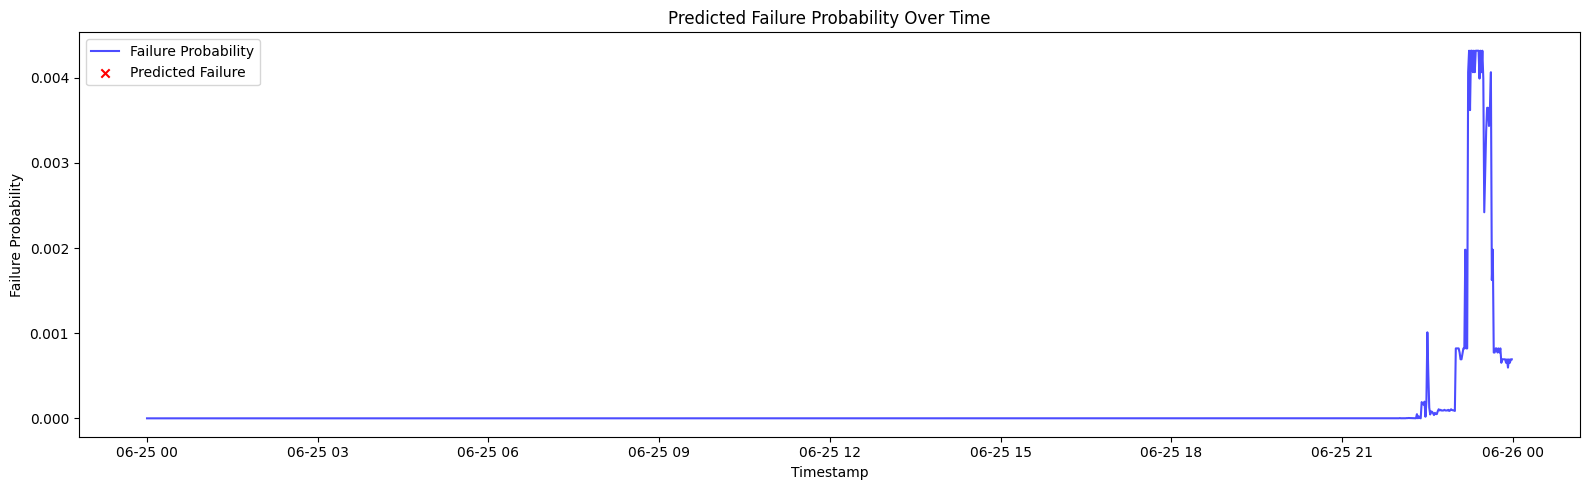


Records predicted as failure:


,Timestamp,Predicted_Failure,Failure_Probability


In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Add src directory to path
sys.path.append('C:/AI_Project/src')
from predict_failure import load_model, prepare_features, predict_failures

# Paths
engineered_features_path = 'C:/AI_Project/data/processed_logs/feature_system_metric_failure.json'  # Use the main engineered features
model_path = 'C:/AI_Project/models/xgboost_model.pkl'

test_df = pd.read_json(engineered_features_path)
target = 'failure_coming'
non_numeric_columns = test_df.select_dtypes(exclude=['number']).columns.tolist()
if target in non_numeric_columns:
    non_numeric_columns.remove(target)
test_columns = [col for col in test_df.columns if col not in non_numeric_columns + [target]]
if target in test_columns:
    test_columns.remove(target)

# Make predictions and get probabilities
results_df = predict_failures(model_path, engineered_features_path, test_columns)

# Set a higher threshold for failure prediction
threshold = 0.8  # Try 0.8 or 0.9 for fewer false positives
results_df['Predicted_Failure'] = (results_df['Failure_Probability'] > threshold).astype(int)

# Display results
print(f"Predictions on synthetic failure data (threshold={threshold}):")
display(results_df.head())

# Plot predictions and failures over time
if 'Timestamp' in test_df.columns:
    results_df = results_df.copy()
    results_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])
    plt.figure(figsize=(16, 5))
    plt.plot(results_df['Timestamp'], results_df['Failure_Probability'], label='Failure Probability', color='blue', alpha=0.7)
    plt.scatter(results_df.loc[results_df['Predicted_Failure'] == 1, 'Timestamp'],
                results_df.loc[results_df['Predicted_Failure'] == 1, 'Failure_Probability'],
                color='red', label='Predicted Failure', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Failure Probability')
    plt.title('Predicted Failure Probability Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Timestamp column not found for plotting.")

# Show number of predicted failures
num_failures = results_df['Predicted_Failure'].sum()
print(f"\nNumber of predicted failures in synthetic failure set: {num_failures}")
if num_failures == 0:
    print("No failures predicted. Check if the failure pattern is strong enough or adjust the threshold.")
else:
    print("Failures detected as expected in the failure set.")


######################################################################################################

# <center>Dignostics</center>

######################################################################################################




Class distribution in training data:
failure_coming
0    4430
1    2921
Name: count, dtype: int64


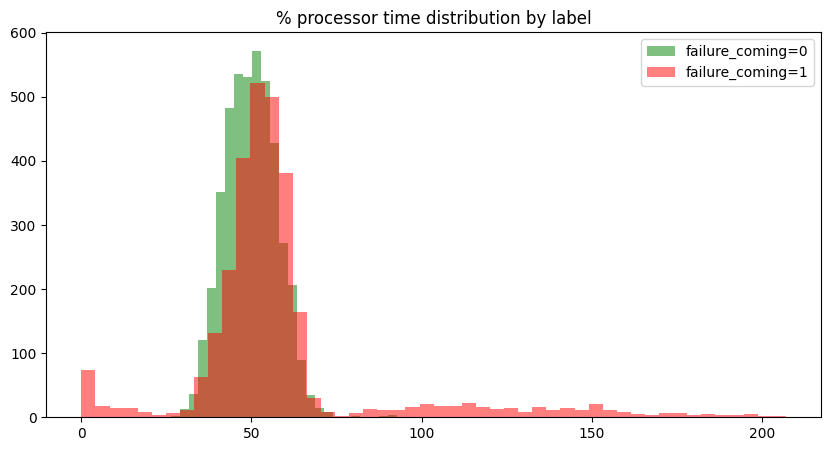


Threshold: 0.5
[[831  66]
 [148 426]]
              precision    recall  f1-score   support

           0      0.849     0.926     0.886       897
           1      0.866     0.742     0.799       574

    accuracy                          0.855      1471
   macro avg      0.857     0.834     0.843      1471
weighted avg      0.855     0.855     0.852      1471


Threshold: 0.7
[[871  26]
 [230 344]]
              precision    recall  f1-score   support

           0      0.791     0.971     0.872       897
           1      0.930     0.599     0.729       574

    accuracy                          0.826      1471
   macro avg      0.860     0.785     0.800      1471
weighted avg      0.845     0.826     0.816      1471


Threshold: 0.8
[[890   7]
 [294 280]]
              precision    recall  f1-score   support

           0      0.752     0.992     0.855       897
           1      0.976     0.488     0.650       574

    accuracy                          0.795      1471
   macro av

In [24]:

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load engineered features with labels (combined data)
df = pd.read_json('C:/AI_Project/data/processed_logs/engineered_features.json')
print("Class distribution in training data:")
print(df['failure_coming'].value_counts())

# Visualize feature distributions for a key metric
plt.figure(figsize=(10,5))
for label, color in zip([0,1], ['green','red']):
    subset = df[df['failure_coming']==label]
    plt.hist(subset['% processor time'], bins=50, alpha=0.5, label=f'failure_coming={label}', color=color)
plt.legend()
plt.title('% processor time distribution by label')
plt.show()

# Evaluate model on test set with different thresholds
from train_model import split_data, load_model
X_train, X_test, y_train, y_test = split_data(df, target='failure_coming')
if 'failure_coming' in X_test.columns:
    X_test = X_test.drop(columns=['failure_coming'])
model = load_model('C:/AI_Project/models/xgboost_model.pkl')
probs = model.predict_proba(X_test)[:,1]

for thresh in [0.5, 0.7, 0.8, 0.9]:
    preds = (probs > thresh).astype(int)
    print(f"\nThreshold: {thresh}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds, digits=3))


Predictions on synthetic success data (threshold=0.8):


,Timestamp,Predicted_Failure,Failure_Probability
0,2025-06-24 00:00:00,0,0.000001
1,2025-06-24 00:01:00,0,0.000001
2,2025-06-24 00:02:00,0,0.000001
3,2025-06-24 00:03:00,0,0.000001
4,2025-06-24 00:04:00,0,0.000001


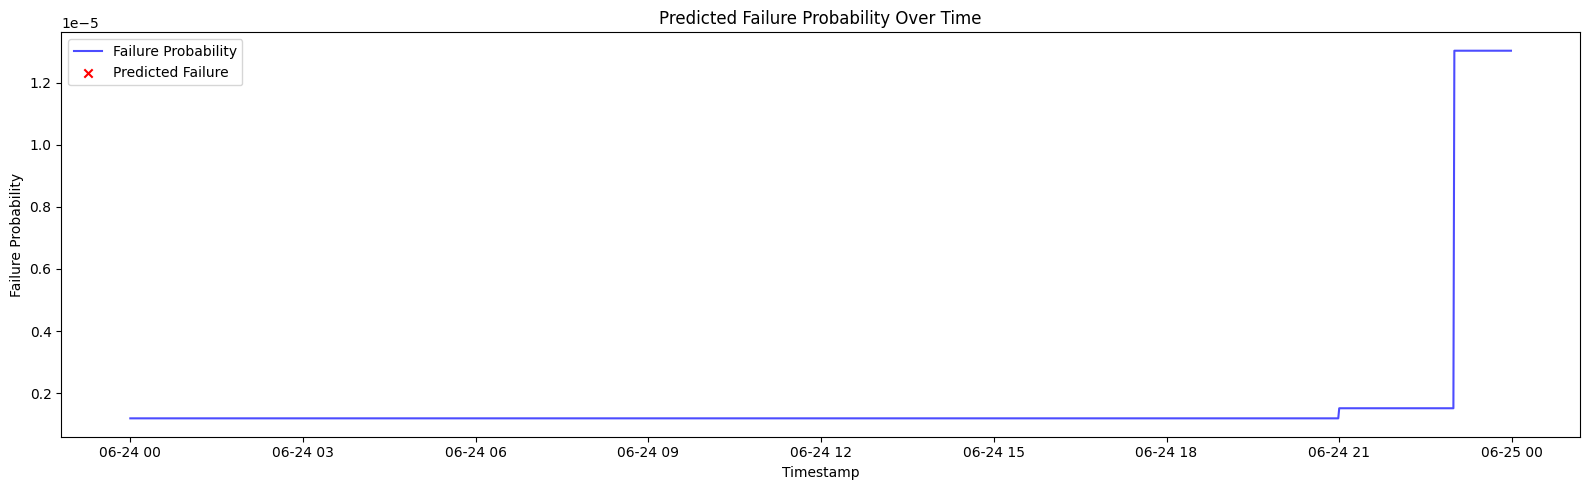


Number of predicted failures in synthetic success set: 0
No failures predicted. Success set is clean at this threshold.


In [32]:

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Add src directory to path
sys.path.append('C:/AI_Project/src')
from predict_failure import load_model, prepare_features, predict_failures

# Paths
engineered_features_path = 'C:/AI_Project/data/processed_logs/feature_system_metric_success.json'
model_path = 'C:/AI_Project/models/xgboost_model.pkl'

# Load features
test_df = pd.read_json(engineered_features_path)
target = 'failure_coming'
non_numeric_columns = test_df.select_dtypes(exclude=['number']).columns.tolist()
if target in non_numeric_columns:
    non_numeric_columns.remove(target)
test_columns = [col for col in test_df.columns if col not in non_numeric_columns + [target]]
if target in test_columns:
    test_columns.remove(target)

# Make predictions and get probabilities
results_df = predict_failures(model_path, engineered_features_path, test_columns)

# Set a higher threshold for failure prediction
threshold = 0.8  # Try 0.8 or 0.9 for fewer false positives
results_df['Predicted_Failure'] = (results_df['Failure_Probability'] > threshold).astype(int)

# Display results
print(f"Predictions on synthetic success data (threshold={threshold}):")
display(results_df.head())

# Plot predictions and failures over time
if 'Timestamp' in test_df.columns:
    results_df = results_df.copy()
    results_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])
    plt.figure(figsize=(16, 5))
    plt.plot(results_df['Timestamp'], results_df['Failure_Probability'], label='Failure Probability', color='blue', alpha=0.7)
    plt.scatter(results_df.loc[results_df['Predicted_Failure'] == 1, 'Timestamp'],
                results_df.loc[results_df['Predicted_Failure'] == 1, 'Failure_Probability'],
                color='red', label='Predicted Failure', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Failure Probability')
    plt.title('Predicted Failure Probability Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Timestamp column not found for plotting.")

# Show number of predicted failures
num_failures = results_df['Predicted_Failure'].sum()
print(f"\nNumber of predicted failures in synthetic success set: {num_failures}")
if num_failures > 0:
    print("Some false positives remain. You may further increase the threshold or improve feature separation.")
else:
    print("No failures predicted. Success set is clean at this threshold.")


Predictions on synthetic failure data (threshold=0.8):


,Timestamp,Predicted_Failure,Failure_Probability
0,2025-06-25 00:00:00,0,0.000001
1,2025-06-25 00:01:00,0,0.000001
2,2025-06-25 00:02:00,0,0.000001
3,2025-06-25 00:03:00,0,0.000001
4,2025-06-25 00:04:00,0,0.000001


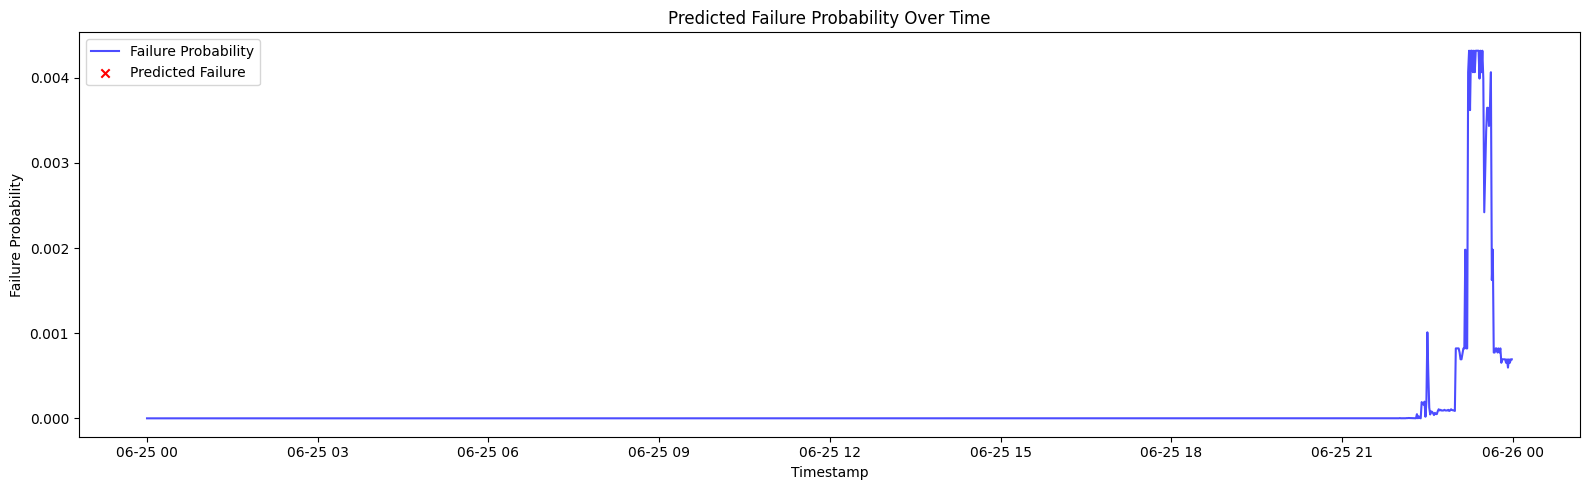


Number of predicted failures in synthetic failure set: 0
No failures predicted. Check if the failure pattern is strong enough or adjust the threshold.


In [ ]:

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Add src directory to path
sys.path.append('C:/AI_Project/src')
from predict_failure import load_model, prepare_features, predict_failures

# Paths
engineered_features_path = 'C:/AI_Project/data/processed_logs/feature_system_metric_failure.json'
model_path = 'C:/AI_Project/models/xgboost_model.pkl'

# Load features
test_df = pd.read_json(engineered_features_path)
target = 'failure_coming'
non_numeric_columns = test_df.select_dtypes(exclude=['number']).columns.tolist()
if target in non_numeric_columns:
    non_numeric_columns.remove(target)
test_columns = [col for col in test_df.columns if col not in non_numeric_columns + [target]]
if target in test_columns:
    test_columns.remove(target)

# Make predictions and get probabilities
results_df = predict_failures(model_path, engineered_features_path, test_columns)

# Set the same threshold for failure prediction
threshold = 0.8  # Use the same threshold as for success data
results_df['Predicted_Failure'] = (results_df['Failure_Probability'] > threshold).astype(int)

# Display results
print(f"Predictions on synthetic failure data (threshold={threshold}):")
display(results_df.head())

# Plot predictions and failures over time
if 'Timestamp' in test_df.columns:
    results_df = results_df.copy()
    results_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])
    plt.figure(figsize=(16, 5))
    plt.plot(results_df['Timestamp'], results_df['Failure_Probability'], label='Failure Probability', color='blue', alpha=0.7)
    plt.scatter(results_df.loc[results_df['Predicted_Failure'] == 1, 'Timestamp'],
                results_df.loc[results_df['Predicted_Failure'] == 1, 'Failure_Probability'],
                color='red', label='Predicted Failure', marker='x')
    plt.xlabel('Timestamp')
    plt.ylabel('Failure Probability')
    plt.title('Predicted Failure Probability Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Timestamp column not found for plotting.")

# Show number of predicted failures
num_failures = results_df['Predicted_Failure'].sum()
print(f"\nNumber of predicted failures in synthetic failure set: {num_failures}")
if num_failures == 0:
    print("No failures predicted. Check if the failure pattern is strong enough or adjust the threshold.")
else:
    print("Failures detected as expected in the failure set.")